In [1]:
import pandas as pd  # For dataframe
import numpy as np  # For matrix operations
import sklearn.preprocessing as sklpre  # For preprocessing (scaling)
import sklearn.linear_model as skllm  # For OLS
import sklearn.model_selection as sklms  # For train_test_split
from scipy import stats  # To calc p-value
import matplotlib.pyplot as plt  # For plotting
import pygam  # For generalized additive models
import sklearn.ensemble as sklen  # For ensemble methods
import sklearn.neighbors as sklne  # For nearest neighbors
import sklearn.tree as skltree  # For trees
import sklearn.neural_network as sklnn  # For neural networks
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignoring annoying convergence warnings from Scikit-Learn, we can't expect every neural network to converge
warnings.filterwarnings("ignore", category=ConvergenceWarning)

np.random.seed(len("jeff"))  # Setting seed
# For automatic formatting of code, sparing you from my usually horrible looking code
%load_ext nb_black

<IPython.core.display.Javascript object>

# Task 1.1
I have chosen to one-hot encode the SEX-category, as neither male nor female should be considered adifferent numbers. 
The rest of the categorical values are just true/false, so those aren't encoded. 
Then I scale all the scalar features, not touching the categorical features.

In [2]:
# Reading the data into dataframe
df = pd.read_csv("data_task_1.txt", header=0, sep=" ")
# Onehot-encoding gender
onehot_gender = pd.get_dummies(df["SEX"]).set_axis(
    ["Male", "Female"], axis=1, inplace=False
)
# Replacing old gender column
df = df.join(onehot_gender)
df.drop("SEX", axis=1, inplace=True)
# List of boolean categories
categorical = [
    "ADHEU",
    "HOCHOZON",
    "AMATOP",
    "AVATOP",
    "ADEKZ",
    "ARAUCH",
    "FSNIGHT",
    "FSPT",
    "FSATEM",
    "FSAUGE",
    "FSPFEI",
    "FSHLAUF",
    "Male",
    "Female",
]

# A loop that splits the data and tries again until there is no split where only one modality is in one split
first = True
while (
    first
    or np.any(
        np.logical_or(X_train.sum(axis=0) == 0, X_train.sum(axis=0) == X_train.shape[0])
    )
    or np.any(
        np.logical_or(X_test.sum(axis=0) == 0, X_test.sum(axis=0) == X_test.shape[0])
    )
):
    first = False
    # Splitting over and over until splits are good, stratifying the most biased feature.
    X_train, X_test, y_train, y_test = sklms.train_test_split(
        df.loc[:, df.columns != "FFVC"],
        df["FFVC"],
        test_size=0.5,
        stratify=df["FSATEM"],
    )
# Scaling scalar features based on train set
scaler = sklpre.StandardScaler()
X_train_continous = scaler.fit_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))].values
)
X_test_continous = scaler.transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))].values
)
# Putting all scalar and categorical features together
X_train.loc[
    :, np.logical_not(np.isin(X_train.columns, categorical))
] = X_train_continous
X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))] = X_test_continous
# Need to specify datatypes because it chose a dumb datatype by default
X_train = X_train.astype({"Male": "int32", "Female": "int32"})
X_test = X_test.astype({"Male": "int32", "Female": "int32"})
# All preprocessing done!

<IPython.core.display.Javascript object>

# Task 1.2
Running OLS, calculating uncertainties and p-values

In [3]:
def get_summary_linear_model(model, X_train, y_train):
    """
    Scikit-learn has no built in support for confidence intervals and p-values, so I 
    made this to calculate it for me after fitting the model. Put into a function for reuse.
    """
    # Combining intercept and coefficients in same array
    coefficients = np.append(model.intercept_, model.coef_)

    # Predicting y
    y_hat = model.predict(X_train)
    # Calculating RSS to get variance for use when calculating stddev of coeffs
    residuals = y_train.values - y_hat
    rss = residuals.reshape(-1, 1).T @ residuals.reshape(-1, 1)
    var = rss[0, 0] / (len(X_train) - len(X_train.columns) - 1)

    # Adding intercept to X_train, as sklearn usually does not need the column of 1's
    X_with_intercept = np.append(
        np.ones(X_train.shape[0]).reshape(-1, 1), X_train, axis=1
    )
    # Stddev of coefficients
    stddev = np.sqrt(
        (np.diag(var * np.linalg.pinv(X_with_intercept.T @ X_with_intercept)))
    )
    labels = ["Intercept"] + X_train.columns.tolist()

    coef_over_std = coefficients / stddev
    p_values = [
        2 * (1 - stats.t.cdf(np.abs(i), (len(X_with_intercept) - 1)))
        for i in coef_over_std
    ]

    # Putting results into table
    coeffs_table = pd.DataFrame(zip(labels, coefficients, stddev, p_values))
    # Giving nice names with TeX formatting
    coeffs_table.rename(
        columns={0: "Feature", 1: r"$\beta_i$", 2: r"$\pm$", 3: "p-values"},
        inplace=True,
    )
    return coeffs_table

<IPython.core.display.Javascript object>

In [4]:
# OLS on train data
ols_reg = skllm.LinearRegression().fit(X_train, y_train)
# R2 score
r2 = ols_reg.score(X_test, y_test)
coeffs_table = get_summary_linear_model(ols_reg, X_train, y_train)
most_important = coeffs_table["Feature"].values[1:][
    np.argmin(coeffs_table["p-values"].values[1:])
]
# Printing results
print(f"Got an R^2 score of {r2:.2f} for the test set.")
print(f"The most important feature (lowest p-value) is {most_important}.")
coeffs_table

Got an R^2 score of 0.65 for the test set.
The most important feature (lowest p-value) is FLGROSS.


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.314333,0.028610,0.000000e+00
1,ALTER,0.021497,0.016804,2.020056e-01
2,ADHEU,-0.086719,0.065251,1.850741e-01
3,HOCHOZON,-0.113580,0.042905,8.637147e-03
4,AMATOP,0.044360,0.034373,1.980698e-01
5,AVATOP,-0.040302,0.034556,2.446285e-01
6,ADEKZ,-0.014503,0.037623,7.002223e-01
7,ARAUCH,-0.029416,0.031876,3.569903e-01
8,AGEBGEW,0.000868,0.015130,9.543048e-01
9,FSNIGHT,0.061645,0.051301,2.306612e-01


<IPython.core.display.Javascript object>

The most important (lower p-value) feature seems to be FLGROSS. Some other important features seem to be gender. Male and female seem to completely cancel each other, implying that men are of higher risk?

# Task 1.3
Scikit-learn for some reason doesn't have built in forward and backward selection, so I will create my own functions!

In [5]:
def backward_elimination(regressor, X_train, y_train, max_p_limit):
    """
    Takes a regressor, training set and a max p-value, runs backward
    elimination and returns the regresson fitted on the reduced
    features, the reduced feature matrix, a table of betas, 
    standard deviations and p-values and the removed features
    """
    # Fitting regressor on full model
    regressor.fit(X_train, y_train)
    # Getting table of p-values to find what to eliminate
    result_table = get_summary_linear_model(regressor, X_train, y_train)
    p_values = result_table["p-values"].values
    p_val_max, p_val_max_pos = p_values[1:].max(), p_values[1:].argmax() + 1
    # Getting name of feature with highest p-val to make list of removed features
    feature_max_p_val = result_table["Feature"][p_val_max_pos]
    removed_features = [feature_max_p_val]
    # Dropping feature with highest p-val
    X_reduce = X_train.drop(columns=feature_max_p_val, inplace=False)
    # Running backwards elimination until all p-values are below limit
    while p_val_max > max_p_limit:
        # Fitting on reduced model
        regressor.fit(X_reduce, y_train)
        result_table = get_summary_linear_model(regressor, X_reduce, y_train)
        p_values = result_table["p-values"].values
        p_val_max, p_val_max_pos = p_values[1:].max(), p_values[1:].argmax() + 1
        feature_max_p_val = result_table["Feature"][p_val_max_pos]
        # If one or more features have to high p-value, remove
        if p_val_max > max_p_limit:
            # Append name to list that keeps track of removed features
            removed_features.append(feature_max_p_val)
            # Dropping feature
            X_reduce.drop(columns=feature_max_p_val, inplace=True)
            # Sorting features
            X_reduce.sort_index(axis=1, inplace=True)
            # Fitting reduced model
            regressor.fit(X_reduce, y_train)

    return regressor, X_reduce, result_table, removed_features

<IPython.core.display.Javascript object>

In [6]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced,
    X_reduce_train,
    result_table_reduced,
    removed_features,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test = X_test.drop(columns=removed_features).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f} Backward Model: {regressor_reduced.score(X_reduce_test, y_test):.2f}"
)
result_table_reduced

R^2 score of full model: 0.65 Backward Model: 0.66


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.267274,0.009212,0.000000e+00
1,FLGEW,0.059817,0.019108,1.954982e-03
2,FLGROSS,0.193067,0.019126,0.000000e+00
3,Female,-0.097007,0.014604,1.948932e-10
4,Male,0.097007,0.014675,2.343874e-10


<IPython.core.display.Javascript object>

In [7]:
def forward_selection(regressor, X_train, y_train, max_p_limit):
    """
    Takes a regressor, training set and a max p-value, runs forward
    selection and returns the regresson fitted on the reduced
    features, the reduced feature matrix, a table of betas, 
    standard deviations and p-values and the removed features
    """
    X_null = pd.DataFrame({"null": np.zeros_like(y_train)})
    regressor.fit(X_null, y_train)
    # The p-value for the 0-column is invalid, but also not used, so I ignore the warnings
    with np.errstate(invalid="ignore"):
        # Getting results for null-model
        result_table = get_summary_linear_model(regressor, X_null, y_train)
    # p-value for intercept
    p_val_max = result_table["p-values"][0]
    # Dataframe used for incresing
    X_increased = pd.DataFrame()
    # List of features
    features = X_train.columns.values
    # while max p-val is below threshold, repeat
    while p_val_max < max_p_limit:
        # Set best p to infinity so that all values are less
        best_p = np.inf
        # Looping over features
        for feature in features:
            # Creating new column with feature in loop
            new_col = pd.DataFrame({feature: X_train[feature].values})
            # If null model we need to append to the dataframe differently than usual
            if len(X_increased.values) == 0:
                # Adding new feature to null model
                X_candidate = X_increased.append(new_col)
            else:
                # Adding new feature to model
                new_col_names = np.append(
                    X_increased.columns.values, new_col.columns.values
                )
                X_candidate = pd.DataFrame(
                    np.append(X_increased.values, new_col.values, axis=1),
                    columns=new_col_names,
                )
            # Fitting increased model to find p-value
            regressor.fit(X_candidate, y_train)
            result_table = get_summary_linear_model(regressor, X_candidate, y_train)
            p_i = result_table["p-values"].values[-1]
            # This if-statement is used to find the minimum p-value of the potential features to add
            if p_i < best_p:
                best_p = p_i
                best_new_feature = feature
        # Now that we have the best feature to add, we add it properly
        new_col = pd.DataFrame({best_new_feature: X_train[best_new_feature].values})
        if len(X_increased.values) == 0:
            X_candidate = X_increased.append(new_col)
        else:
            new_col_names = np.append(
                X_increased.columns.values, new_col.columns.values
            )
            X_candidate = pd.DataFrame(
                np.append(X_increased.values, new_col.values, axis=1),
                columns=new_col_names,
            )
        # Get results for new model
        result_table = get_summary_linear_model(regressor, X_candidate, y_train)
        p_val_max = result_table["p-values"].values.max()

        # Sorting features
        X_increased = X_candidate.sort_index(axis=1)
        # Removing added feature from list of potential featues so that we can't add it again next iteration
        features = features[features != best_new_feature]

    # List of omitted features
    omitted_features = features
    # Fitting increased model
    regressor.fit(X_increased, y_train)
    # Table of results for best model
    result_table_best = get_summary_linear_model(regressor, X_increased, y_train)
    return regressor, X_increased, result_table_best, omitted_features

<IPython.core.display.Javascript object>

In [8]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased,
    X_increased_train,
    result_table_increased,
    omitted_features_increased,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test = X_test.drop(columns=omitted_features_increased).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased.score(X_increased_test, y_test):.2f}"
)
result_table_increased

R^2 score of forward model: 0.66


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.267274,0.009212,0.000000e+00
1,FLGEW,0.059817,0.019108,1.954982e-03
2,FLGROSS,0.193067,0.019126,0.000000e+00
3,Female,-0.097007,0.014604,1.948932e-10
4,Male,0.097007,0.014675,2.343874e-10


<IPython.core.display.Javascript object>

For the reduced models with $p_\text{max}=0.01$, both forward and backward selection give the exact same model, and therefore the same features. They also get a slightly better $R^2$-score, possibly because they have less features, and are therefore less likely to overfit on the training data. I chose to look at $R^2$ instead of MSE as I feel it is a more intuitive value. However, higher $R^2$ also implies lower MSE, so the models are better.

Next I will test with a less strict $p_\text{max}=0.1$ and see how the models perform:

In [9]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced_less_strict,
    X_reduce_train_less_strict,
    result_table_reduced_less_strict,
    removed_features_less_strict,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test_less_strict = X_test.drop(
    columns=removed_features_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f}"
    + f" Backward Model: {regressor_reduced_less_strict.score(X_reduce_test_less_strict, y_test):.2f}"
)
result_table_reduced_less_strict

R^2 score of full model: 0.65 Backward Model: 0.67


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.325300,0.020509,0.000000e+00
1,FLGEW,0.061588,0.018903,1.278942e-03
2,FLGROSS,0.193914,0.019226,0.000000e+00
3,FLTOTMED,-0.028568,0.014493,4.982569e-02
4,FNOH24,-0.043130,0.019478,2.772511e-02
5,FO3H24,0.065094,0.028925,2.530011e-02
6,FPOLL,-0.033717,0.014188,1.824031e-02
7,FSPFEI,0.127272,0.059145,3.237879e-02
8,FTEH24,-0.048164,0.026385,6.914913e-02
9,Female,-0.100690,0.017013,1.079644e-08


<IPython.core.display.Javascript object>

In [10]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased_less_strict,
    X_increased_train_less_strict,
    result_table_increased_less_strict,
    omitted_features_increased_less_strict,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test_less_strict = X_test.drop(
    columns=omitted_features_increased_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased_less_strict.score(X_increased_test_less_strict, y_test):.2f}"
)
result_table_increased_less_strict

R^2 score of forward model: 0.66


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.267274,0.009212,0.000000e+00
1,FLGEW,0.059817,0.019108,1.954982e-03
2,FLGROSS,0.193067,0.019126,0.000000e+00
3,Female,-0.097007,0.014604,1.948932e-10
4,Male,0.097007,0.014675,2.343874e-10


<IPython.core.display.Javascript object>

Now the models are not the same anymore. This is to be expected, as the p-values estimated are not the same for each feature independent of the other features. The backward elimination model seems to give a better $R^2$-score this time.

# Task 1.4
CV is easily implemented in Scikit-Learn. Bootstap on the other hand... I need to create my own class (Maybe there is a better way of doing this than what I'm doing...)

In [11]:
# 5-fold cross validation, n-jobs=-1 is for parallelisation (use multiple cpu cores)
lasso_cv = skllm.LassoCV(n_jobs=-1, cv=5).fit(X_train, y_train)
# List of hyperparameters
lambdas_lasso_cv = lasso_cv.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 5 folds
mses_lasso_cv = lasso_cv.mse_path_.mean(axis=1)
print(
    f"Best hyperparameter is {lasso_cv.alpha_:.2e}, giving a test R^2 score of {lasso_cv.score(X_test, y_test):.2f}"
)

Best hyperparameter is 1.04e-02, giving a test R^2 score of 0.65


<IPython.core.display.Javascript object>

This seems to be very similar to forward and backward selection. Now I need to make a new class for bootstrap manually implemented.

In [12]:
class Bootstrap:
    def __init__(self, y):
        """
        I was sort of confused on how to this, so I just made a class and tried stuff. 
        Now it works, so I won't change it anymore.
        This class takes y_train and saves its length.
        """
        self.len_y = len(y)

    @property
    def get_bootstrap(self):
        """
        This method returns one train-validation bootstrap split of the training data (indices of the data).
        The @property is just so that i can call get_bootstrap without the () after (like in get_bootstrap()).
        This splits train and validation into 2/3, 1/3 of the length of the data. Not sure if that is the correct
        method.
        """
        # All indices (0-lenght of y)
        indices = np.arange(self.len_y)
        # Picking random indices with replacement.
        indices_train = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.67)
        )
        indices_validate = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.37)
        )
        # Returns a list of lists
        return [indices_train.tolist(), indices_validate.tolist()]


# Creating instance of Bootstrap class
bootstrap = Bootstrap(y_train)
splits = []
# This loops creates 100 different bootstrap samples
for i in range(100):
    splits.append(bootstrap.get_bootstrap)
# Running LassoCV with bootstrap instead of CV.
lasso_bootstrap = skllm.LassoCV(n_jobs=-1, cv=splits).fit(X_train, y_train)

# Lambdas tried by the solver
lambdas_lasso_bootstrap = lasso_bootstrap.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 100 bootstraps
mses_lasso_bootstrap = lasso_bootstrap.mse_path_.mean(axis=1)

print(
    f"Best hyperparameter is {lasso_bootstrap.alpha_:.2e}, giving a test R^2 score of {lasso_bootstrap.score(X_test, y_test):.2f}"
)

Best hyperparameter is 3.39e-03, giving a test R^2 score of 0.66


<IPython.core.display.Javascript object>

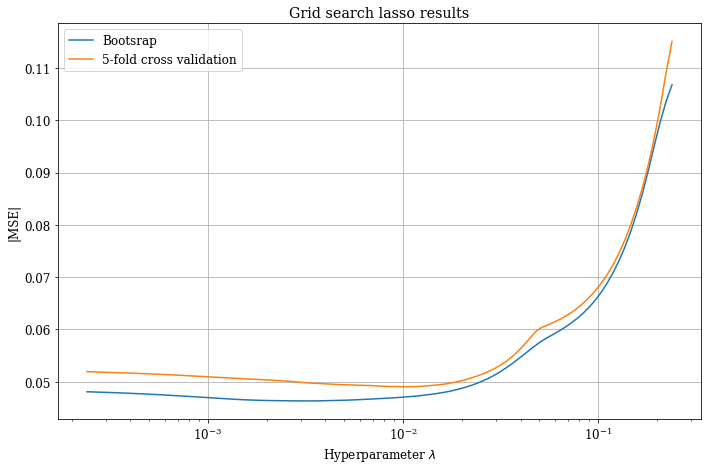

<IPython.core.display.Javascript object>

In [13]:
# Fixing font sizes of plots
fonts = {
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}

plt.rcParams.update(fonts)

# Log plot
plt.figure(figsize=(10, 6.7))
plt.semilogx(lambdas_lasso_bootstrap, mses_lasso_bootstrap, label="Bootsrap")
plt.semilogx(lambdas_lasso_cv, mses_lasso_cv, label="5-fold cross validation")
plt.xlabel(r"Hyperparameter $\lambda$")
plt.ylabel(r"|MSE|")
plt.title("Grid search lasso results")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Bootstrap and cross validation seem to estimate the error quite similarily. CV is probably a bit more realistic, as the error is a bit higher, but that i not important. The important thing is where the minimum is, and it seems to be almost the same for both methods.

# Task 1.5

To determine which features are nonlinear, I plot them all:

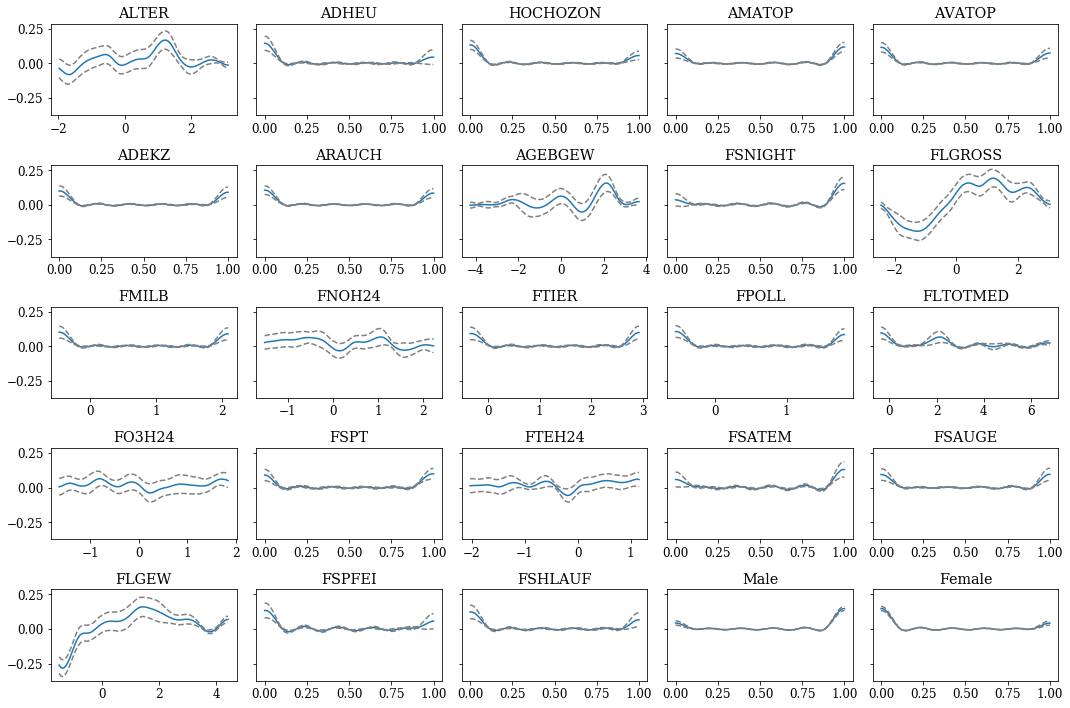

<IPython.core.display.Javascript object>

In [14]:
# Creating gam instance to plot
gam_test = pygam.LinearGAM().fit(X_train.values, y_train.values)
# Plotting
fig, axes = plt.subplots(5, 5, figsize=[15, 10], sharey=True)
for i, ax in enumerate(axes.ravel()):
    XX = gam_test.generate_X_grid(i)
    pdep, confi = gam_test.partial_dependence(term=i, X=XX, width=0.95, meshgrid=False)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], c="grey", ls="--")
    ax.plot(XX[:, i], confi[:, 1], c="grey", ls="--")
    ax.set_title(X_train.columns.values[i])
fig.tight_layout()
plt.show()

FLGEW, and FLGROSS to me seem nonlinear.

In [44]:
# Splines and betas. pygam.s is a spline, pyham.l is a linear feature.
features_gam = pygam.l(0)

nonlinear_features = ["FLGEW", "FLGROSS"]

# Setting up splines for all non-linear values.
for i, feature in enumerate(X_train.columns.values[1:]):
    if feature in nonlinear_features:
        features_gam += pygam.s(i)
    else:
        features_gam += pygam.l(i)

# Lambdas for ramdomized search of penalties.
lambdas = np.exp(np.random.rand(100, len(features_gam)) * 3 - 3)
# Fitting a GAM-model and searching for best hyperparameters lambda
gam = pygam.LinearGAM(features_gam).gridsearch(
    X_train.values, y_train.values, lam=lambdas
)

100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


<IPython.core.display.Javascript object>

In [45]:
# R^2 score. There was a bug with pygam so I had to calculate it like this.
r2_test_gam = gam._estimate_r2(X_test, y_test)["explained_deviance"]
r2_train_gam = gam._estimate_r2(X_train, y_train)["explained_deviance"]
print(f"R^2 score test: {r2_test_gam:.2f}, R^2 score train: {r2_train_gam:.2f}")

R^2 score test: 0.65, R^2 score train: 0.64


<IPython.core.display.Javascript object>

This seems to make no improvement. I am wondering if something is implemented wrongly or if this was to be expected. 
Could perheps try many more penalties. The increased complexity may have lead to overfitting as seen on the difference between train and test $R^2$.

Next I test with adding higher orders of the nonlinear features.

In [17]:
# Reversing scale of training features, need this to get the second order features. Will scale them again after.
X_train_nonlinear = scaler.inverse_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))]
)
# Reversing scale of testing features, need this to get the second order features. Will scale them again after.
X_test_nonlinear = scaler.inverse_transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))]
)
# Lists to save the nonlinear features and names
nonlinear_columns_train = []
nonlinear_columns_test = []
nonlinear_columns_name = []
# Looping over features
for i, name in enumerate(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))]
):
    # If feature is in nonlinear_features, add it to list of nonlinear features
    if name in nonlinear_features:
        nonlinear_columns_train.append(X_train_nonlinear[:, i] ** 2)
        nonlinear_columns_test.append(X_test_nonlinear[:, i] ** 2)
        nonlinear_columns_name.append(name + "^2")
# Creating columns with right dimensions out of second order features
nonlinear_columns_train = np.array(nonlinear_columns_train).T
nonlinear_columns_test = np.array(nonlinear_columns_test).T
# Scaling the nonlinear features
scaler_nonlinear = sklpre.StandardScaler()
nonlinear_columns_train = scaler_nonlinear.fit_transform(nonlinear_columns_train)
nonlinear_columns_test = scaler_nonlinear.transform(nonlinear_columns_test)
# Creating new dataframes containing the nonlinear features
X_train_nonlinear = pd.DataFrame(
    nonlinear_columns_train, columns=nonlinear_columns_name, index=X_train.index.values
)
X_test_nonlinear = pd.DataFrame(
    nonlinear_columns_test, columns=nonlinear_columns_name, index=X_test.index.values
)
# Creating new dataframes with all features, ready for fit
X_train_nonlinear = X_train.join(X_train_nonlinear)
X_test_nonlinear = X_test.join(X_test_nonlinear)

# Fitting OLS model
regressor_nonlinear = skllm.LinearRegression().fit(X_train_nonlinear, y_train)

# R2 scores
r2_score_nonlinear_train = regressor_nonlinear.score(X_train_nonlinear, y_train)
r2_score_nonlinear_test = regressor_nonlinear.score(X_test_nonlinear, y_test)
print(
    f"R2 score test:{r2_score_nonlinear_test:.2f}, train: {r2_score_nonlinear_train:.2f}"
)
# Printing table of p-values etc.
get_summary_linear_model(regressor_nonlinear, X_train_nonlinear, y_train)

R2 score test:0.62, train: 0.65


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.333132,0.028541,0.000000e+00
1,ALTER,0.023352,0.016571,1.600366e-01
2,ADHEU,-0.110205,0.064810,9.031186e-02
3,HOCHOZON,-0.124566,0.042453,3.658687e-03
4,AMATOP,0.040683,0.033883,2.310271e-01
5,AVATOP,-0.049731,0.034209,1.472911e-01
6,ADEKZ,0.000444,0.037452,9.905588e-01
7,ARAUCH,-0.028092,0.031537,3.739126e-01
8,AGEBGEW,0.000352,0.014916,9.811785e-01
9,FSNIGHT,0.081877,0.051221,1.112064e-01


<IPython.core.display.Javascript object>

Seems to perform about equally to the GAM model. As we can see the p-values aren't very impressive for the new nonlinear features. They also have rather high uncertainties.

# Task 1.6
I can't find an implementation of component-wise boosting, so I will load R into my notebook and try my best there! I feel like R still has many more features than Python when it comes to lesser known statistical learning methods, so I think it is still good to learn the best of both worlds.

In [18]:
%load_ext rpy2.ipython # Loading R into notebook
train_for_r = X_train.join(y_train) # Dataframes to send into R
test_for_r = X_test.join(y_test)

<IPython.core.display.Javascript object>

First I fit a component_wise boost with splines!

In [19]:
%%R -i train_for_r -i test_for_r
# Dataframes are sent into R
library(compboost)
library(ggplot2)
spline_boost = boostSplines(data = train_for_r, target = "FFVC", loss = LossQuadratic$new(), trace=10)

  1/100: risk = 0.054
 10/100: risk = 0.038
 20/100: risk = 0.03
 30/100: risk = 0.026
 40/100: risk = 0.024
 50/100: risk = 0.022
 60/100: risk = 0.021
 70/100: risk = 0.02
 80/100: risk = 0.019
 90/100: risk = 0.019
100/100: risk = 0.018


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.018



<IPython.core.display.Javascript object>

In [20]:
%%R
table(spline_boost$getSelectedBaselearner())


AGEBGEW_spline   ALTER_spline   FLGEW_spline FLGROSS_spline  FNOH24_spline 
             7             11             21             24              2 
 FO3H24_spline  FTEH24_spline  Female_spline    Male_spline 
             5             12             14              4 


<IPython.core.display.Javascript object>

As we can see, not all features are chosen. The FLGROSS is chosen the most, which makes sense, as it had the lowest p-value in our original OLS model as well. 

Next I will do the same for linear regressors.

In [21]:
%%R
linear_boost = boostLinear(data = train_for_r, target = "FFVC", loss = LossQuadratic$new(), trace=10)

  1/100: risk = 0.054
 10/100: risk = 0.039
 20/100: risk = 0.032
 30/100: risk = 0.029
 40/100: risk = 0.027
 50/100: risk = 0.025
 60/100: risk = 0.025
 70/100: risk = 0.024
 80/100: risk = 0.024
 90/100: risk = 0.023
100/100: risk = 0.023


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.023



<IPython.core.display.Javascript object>

In [22]:
%%R
linear_boost$getEstimatedCoef()

$ALTER_linear
              [,1]
[1,] -5.781440e-18
[2,]  8.443146e-03

$FLGEW_linear
             [,1]
[1,] 8.923426e-17
[2,] 4.644789e-02

$FLGROSS_linear
             [,1]
[1,] 4.881892e-16
[2,] 1.803422e-01

$FPOLL_linear
              [,1]
[1,] -9.331164e-18
[2,] -1.952278e-03

$FSNIGHT_linear
             [,1]
[1,] -0.002378388
[2,]  0.021065720

$Female_linear
            [,1]
[1,]  0.08103014
[2,] -0.16076380

$offset
[1] 2.266492



<IPython.core.display.Javascript object>

More or less the same features seem to be selected here as well. FLGROSS having the largest coefficient (Male and female have higher, but they are binary and therefore act differently.)

I didn't manage to get component-wise boosted trees working, sorry!

# Task 1.7

Calculating the train and test MSE for all models:

In [23]:
def mean_squared_error(sklearn_model, X, y):
    """
    Function for computing MSE of scikit-learn models.
    """
    return ((sklearn_model.predict(X) - y) ** 2).mean()

<IPython.core.display.Javascript object>

In [24]:
# MSE train and test of OLS
print(
    f"OLS: train: {mean_squared_error(ols_reg, X_train, y_train):g}"
    + f"  test: {mean_squared_error(ols_reg, X_test, y_test):g}"
)
# MSE train and test of strict forward selection
print(
    f"Increased: train: {mean_squared_error(regressor_increased, X_increased_train, y_train):g}"
    + f"  test: {mean_squared_error(regressor_increased, X_increased_test, y_test):g}"
)
# MSE train and test of less strict forward selection
print(
    f"Increased less strict: train: {mean_squared_error(regressor_increased_less_strict, X_increased_train_less_strict, y_train):g}"
    + f"  test: {mean_squared_error(regressor_increased_less_strict, X_increased_test_less_strict, y_test):g}"
)
# MSE train and test of strict backward elimination
print(
    f"Reduced: train: {mean_squared_error(regressor_reduced, X_reduce_train, y_train):g}"
    + f"  test: {mean_squared_error(regressor_reduced, X_reduce_test, y_test):g}"
)
# MSE train and test of less strict backward elimination
print(
    f"Reduced less strict: train: {mean_squared_error(regressor_reduced_less_strict, X_reduce_train_less_strict, y_train):g}"
    + f"  test: {mean_squared_error(regressor_reduced_less_strict, X_reduce_test_less_strict, y_test):g}"
)
# MSE train and test for LASSO CV
print(
    f"LASSO CV: train: {mean_squared_error(lasso_cv, X_train, y_train):g}"
    + f"  test: {mean_squared_error(lasso_cv, X_test, y_test):g}"
)
# MSE train and test for LASSO bootstrap
print(
    f"LASSO bootstrap: train: {mean_squared_error(lasso_bootstrap, X_train, y_train):g}"
    + f"  test: {mean_squared_error(lasso_bootstrap, X_test, y_test):g}"
)
# MSE train and test for GAM
print(
    f"GAM: train: {mean_squared_error(gam, X_train, y_train):g}"
    + f"  test: {mean_squared_error(gam, X_test, y_test):g}"
)

OLS: train: 0.0411125  test: 0.0460966
Increased: train: 0.0463959  test: 0.0448621
Increased less strict: train: 0.0463959  test: 0.0448621
Reduced: train: 0.0463959  test: 0.0448621
Reduced less strict: train: 0.043149  test: 0.0437728
LASSO CV: train: 0.0461212  test: 0.0460014
LASSO bootstrap: train: 0.0431835  test: 0.0447356
GAM: train: 0.0411193  test: 0.0460086


<IPython.core.display.Javascript object>

In [25]:
%%R
# Sorry if printing is done in a weird way here, not used to R!
library(MLmetrics)
print("Element-wise spline boosting:")
print("Train: ")
print(MSE(y_pred=data.matrix(spline_boost$predict(train_for_r)), y_true=data.matrix(train_for_r["FFVC"])))
print("Test: ")
print("N/A")
# The commented line under crashes everything!
#print(MSE(y_pred=data.matrix(spline_boost$predict(test_for_r)), y_true=data.matrix(test_for_r["FFVC"])))

print("Element-wise linear boosting:")
print("Train: ")
print(MSE(y_pred=data.matrix(linear_boost$predict(train_for_r)), y_true=data.matrix(train_for_r["FFVC"])))
print("Test: ")
print(MSE(y_pred=data.matrix(linear_boost$predict(test_for_r)), y_true=data.matrix(test_for_r["FFVC"])))

R[write to console]: 
Attaching package: ‘MLmetrics’


R[write to console]: The following object is masked from ‘package:base’:

    Recall




[1] "Element-wise spline boosting:"
[1] "Train: "
[1] 0.03643842
[1] "Test: "
[1] "N/A"
[1] "Element-wise linear boosting:"
[1] "Train: "
[1] 0.04649712
[1] "Test: "
[1] 0.04679446


<IPython.core.display.Javascript object>

Unfortunately compboost crashes when I try to use it to predict with data different from what it was fit on. Makes no sense if you ask me, but therefore I couldn't get it to print the test MSE.

The best models actually seem to be the forward and backward OLS-models, surprisingly!

# Task 2.1

In [26]:
# Using R only for the lines with %R.
%R library(mlbench)
# Loading dataframe
%R data(PimaIndiansDiabetes)
# Now saving the dataframe in a Pandas dataframe in Python instead.
# This is actually really cool, just found out how to do it. Using
# Python together with R this way is probably very useful in data science!
df_2 = %R PimaIndiansDiabetes
# Set feature matrix
X_2 = df_2.loc[:, df_2.columns != "diabetes"]
# Set outcome vector
y_2 = df_2["diabetes"]
# Creating integer version of outcomes
y_2 = (y_2.values == "neg").astype(np.int)
# Creating new dataframe
y_2 = pd.DataFrame(y_2, columns=["diabetes"])
# Splitting test train, stratified based on outcome
X_train_2, X_test_2, y_train_2, y_test_2 = sklms.train_test_split(
    X_2, y_2, stratify=y_2, test_size=0.33
)
# Scaling
scaler_2 = sklpre.StandardScaler()
X_train_2 = pd.DataFrame(scaler_2.fit_transform(X_train_2), columns=X_train_2.columns)
X_test_2 = pd.DataFrame(scaler_2.transform(X_test_2), columns=X_test_2.columns)

<IPython.core.display.Javascript object>

In [27]:
# Leave one out class
loo = sklms.LeaveOneOut()
# Base k-NN classifier used for grid search
base_knn = sklne.KNeighborsClassifier()
# k-s to grid over
k_grid = np.arange(1, 100)
hyperparams = {"n_neighbors": k_grid}
# Grid search using 5-fold
grid_search_knn_5_fold = sklms.GridSearchCV(
    base_knn, param_grid=hyperparams, cv=5, iid=False
)
grid_search_knn_5_fold.fit(
    X_train_2.values, y_train_2.values.ravel(),
)
# Grid search using LOO
grid_search_knn_loo = sklms.GridSearchCV(
    base_knn, param_grid=hyperparams, cv=loo, iid=False
)
grid_search_knn_loo.fit(
    X_train_2.values, y_train_2.values.ravel(),
)

# Test scores
test_scores = np.zeros_like(k_grid).astype(np.float)
for i, k in enumerate(k_grid):
    knn_tmp = sklne.KNeighborsClassifier(n_neighbors=k).fit(
        X_train_2.values, y_train_2.values.ravel()
    )
    test_scores[i] = knn_tmp.score(X_test_2.values, y_test_2.values.ravel())

<IPython.core.display.Javascript object>

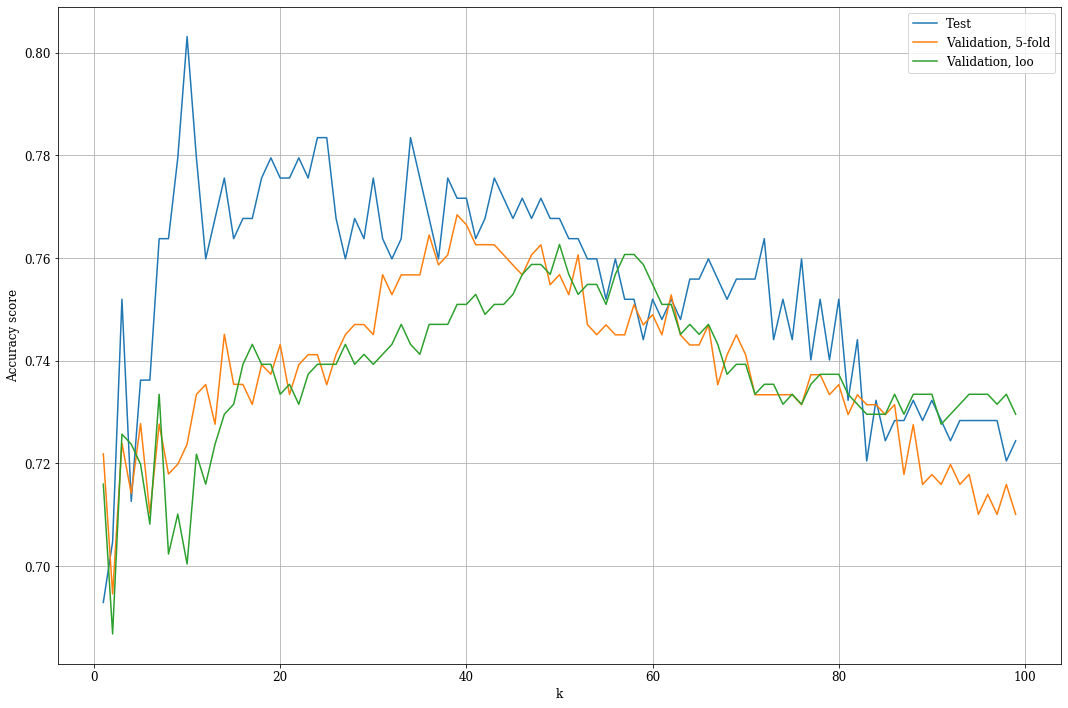

<IPython.core.display.Javascript object>

In [28]:
# Plotting
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(k_grid, test_scores, label="Test")
ax.plot(
    k_grid,
    grid_search_knn_5_fold.cv_results_["mean_test_score"],
    label="Validation, 5-fold",
)
ax.plot(
    k_grid, grid_search_knn_loo.cv_results_["mean_test_score"], label="Validation, loo"
)
ax.grid()
ax.set_xlabel("k")
ax.set_ylabel("Accuracy score")
ax.legend()
fig.tight_layout()
plt.show()

It seems like 5-fold and loo perform very similarily. The difference is that 5-fold is much less computationally expensive, as it has fewer splits. Both of them seem to miss the maximum point of the train set, and will therefore lead to a slight overfit.

# Task 2.2

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


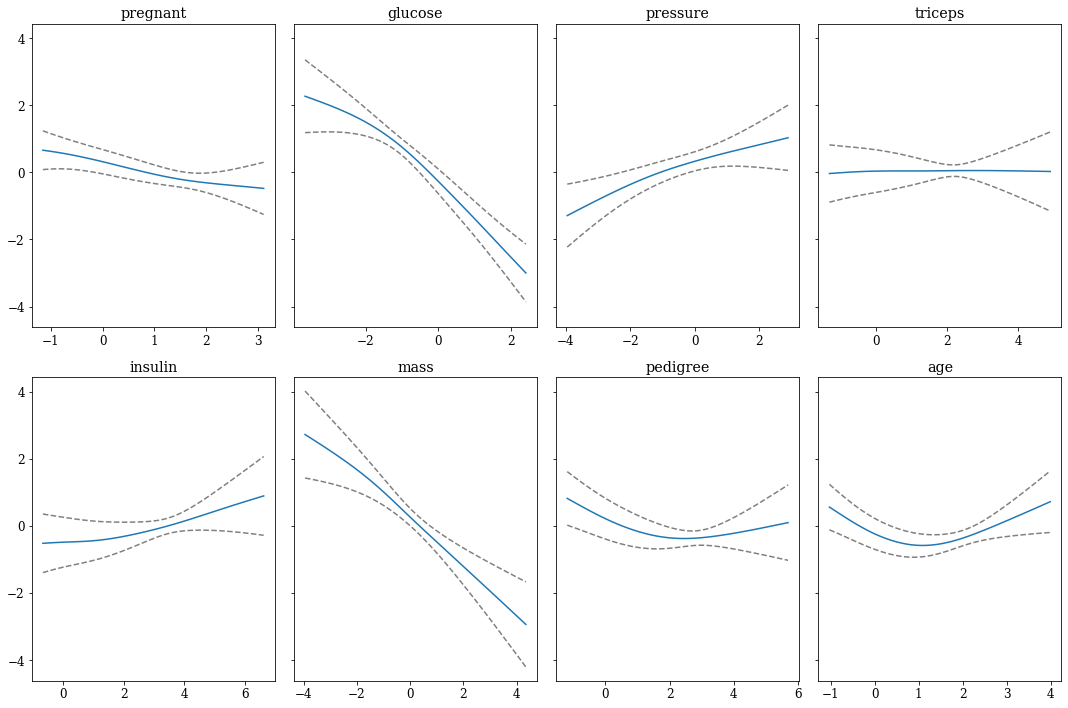

<IPython.core.display.Javascript object>

In [29]:
# Creating a model with only splines
splines = pygam.s(0)

for i in range(1, len(X_train_2.columns)):
    splines += pygam.s(i)
with np.errstate(invalid="ignore", divide="ignore"):
    gam_test_2 = pygam.LogisticGAM(splines).gridsearch(
        X_train_2.values, y_train_2.values
    )
# Plotting partial dependencies (This plotting code was more or less copied from the internet)
fig, axes = plt.subplots(2, 4, figsize=[15, 10], sharey=True)
for i, ax in enumerate(axes.ravel()):
    XX = gam_test_2.generate_X_grid(i)
    pdep, confi = gam_test_2.partial_dependence(
        term=i, X=XX, width=0.95, meshgrid=False
    )
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], c="grey", ls="--")
    ax.plot(XX[:, i], confi[:, 1], c="grey", ls="--")
    ax.set_title(X_train_2.columns.values[i])
fig.tight_layout()
plt.show()

I couldn't get subset selection to work with p-values here, as pyGAM has a bug with p-values. I'm guessing it's just better to use R for this task right now, but I couldn't figure out how. Sorry...

# Task 2.3
Tree first:

In [30]:
# Decision tree
tree_1 = skltree.DecisionTreeClassifier()
# Max depths to try
max_depth_list = np.arange(1, 100)
hyperparams_tree = {"max_depth": max_depth_list}
# Performing grid search with 5-fold cross validation
grid_search_tree_1 = sklms.GridSearchCV(
    tree_1, param_grid=hyperparams_tree, iid=False, cv=5
).fit(X_train_2.values, y_train_2.values.ravel())
print(
    f"Best depth: {grid_search_tree_1.best_params_} "
    + f"Test Score: {grid_search_tree_1.score(X_test_2.values, y_test_2.values.ravel()):.2f}"
)

Best depth: {'max_depth': 2} Test Score: 0.73


<IPython.core.display.Javascript object>

I expect trees to be the worst estimator, especially since the max depth is only 2!

Bagged trees (probability):

In [31]:
# Running cross validation to find best number of trees
candidate_n_estimators = np.arange(1, 50)
hyperparams_bag = {"n_estimators": candidate_n_estimators}

# Base bagging classifier to run CV on
bag_proba = sklen.BaggingClassifier()
# Running grid search
grid_search_bag_proba_1 = sklms.GridSearchCV(
    bag_proba, param_grid=hyperparams_bag, cv=5, iid=False, n_jobs=-1
).fit(X_train_2.values, y_train_2.values.ravel())

print(
    f"Best amount of trees: {grid_search_bag_proba_1.best_params_} "
    + f"Test score: {grid_search_bag_proba_1.score(X_test_2, y_test_2.values.ravel()):.2f}"
)

Best amount of trees: {'n_estimators': 22} Test score: 0.72


<IPython.core.display.Javascript object>

Bagged trees with probability perform slightly worse than a single tree, meaning it probably overfit slightly.

Next up is concencus bagged trees. I expect these to perform slightly worse or equally to probability bagged trees. Unfortunately Scikit-Learn has no way to actually implement this, and I don't have time to learn how to do it in R. Sorry! I know from the lectures however that we expect slightly better result from probability than from voting.

Next up is a random forest:

In [32]:
# Base forest classifier to run grid search on
forest = sklen.RandomForestClassifier()
hyperparameters_forest = {
    "n_estimators": candidate_n_estimators,
    "max_depth": max_depth_list,
}
# Will take long time for grid search here, so I use random search instead.

random_search_forest_1 = sklms.RandomizedSearchCV(
    estimator=forest,
    cv=5,
    iid=False,
    param_distributions=hyperparameters_forest,
    n_iter=100,
).fit(X_train_2.values, y_train_2.values.ravel())

print(
    f"Best hyperparameters: {random_search_forest_1.best_params_} "
    + f"Test score: {random_search_forest_1.score(X_test_2.values, y_test_2.values.ravel()):.2f}"
)

Best hyperparameters: {'n_estimators': 23, 'max_depth': 31} Test score: 0.74


<IPython.core.display.Javascript object>

This seems slightly better or equal to the bagging classifiers. As we have two hyperparameters, we use random search instead of grid search, and to get a better result we could have used more samples, or used distributions instead of grids to sample from.

Next I will use neural networks. Ideally we should use Tensorflow in Python, but I will stay within Scikit-Learn and use their more basic implementation with a sigmoid activation function in each layer.

I choose to test different values of $L_2$ penalty, batch size and learning rate.

In [33]:
penalty_nn_candidates = np.logspace(-3, 0, 100)
batch_size_nn_candidates = np.arange(10, 200)
learning_rate_nn_candidates = np.logspace(-4, 0, 100)
hyperparameters_nn = {
    "alpha": penalty_nn_candidates,
    "batch_size": batch_size_nn_candidates,
    "learning_rate_init": learning_rate_nn_candidates,
}
# Base neural network with two hidden layers, one with 50 nodes, one with 25. Using Sigmoid activation.
neural_network = sklnn.MLPClassifier(hidden_layer_sizes=[50, 25], activation="logistic")
# Random search to find best hyperparameters
random_search_nn_1 = sklms.RandomizedSearchCV(
    estimator=neural_network, param_distributions=hyperparameters_nn, cv=5, iid=False,
).fit(X_train_2.values, y_train_2.values.ravel())
print(
    f"Best hyperparameters: {random_search_nn_1.best_params_} "
    + f"Test score: {random_search_nn_1.score(X_test_2.values, y_test_2.values.ravel()):.2f} "
)

Best hyperparameters: {'learning_rate_init': 0.006579332246575682, 'batch_size': 74, 'alpha': 0.026560877829466867} Test score: 0.78 


<IPython.core.display.Javascript object>

The neural network performs a bit better, but not by much, and we also have to tune way more hyperparameters here. We should ideally also try with different layer sizes and more layers, different activation functions, etc...

Next up is AdaBoost:

In [34]:
# Base ada classifier to run random search on
ada = sklen.AdaBoostClassifier()
# Hyperparameters candidates:
n_estimators_ada = np.arange(1, 100)
learning_rate_ada = np.logspace(-3, 0, 100)
hyperparameters_ada = {
    "n_estimators": n_estimators_ada,
    "learning_rate": learning_rate_ada,
}
# Running random search to find best hyperparams
random_search_ada_1 = sklms.RandomizedSearchCV(
    estimator=ada, param_distributions=hyperparameters_ada, cv=5, iid=False,
).fit(X_train_2.values, y_train_2.values.ravel())
print(
    f"Best hyperparameters: {random_search_ada_1.best_params_} "
    + f"Test score: {random_search_ada_1.score(X_test_2.values, y_test_2.values.ravel()):.2f} "
)

Best hyperparameters: {'n_estimators': 55, 'learning_rate': 0.12328467394420659} Test score: 0.78 


<IPython.core.display.Javascript object>

Similar performance to neural network.

# Task 2.4
I would use AdaBoost, as it performs similarily to a neural network, and has much fewer hyperparameters. I am fairly convinced that you could make the neural network perform even better here with more tuning, but that is sort of an argument against neural networks as well, as that would be much more computationally expensive.

The single tree and bagged tree models perform noticably worse, but then again there are few cases where one would want to use these models instead of a random forest or boosted model. The one argument I can see for a decision tree is that it is the most interpretable and portable model, though.

# Task 2.5

Here I will quickly run all the models on the new dataset after downloading it. (Please forgive me for copy/pasting the code instead of just making functions!)

In [35]:
# Loading dataframe using R together with Python
%R data(PimaIndiansDiabetes2)
df_3 = %R PimaIndiansDiabetes2
# Dropping all rows with NaN
df_3.dropna(inplace=True)
X_3 = df_3.loc[:, df_3.columns != "diabetes"]
y_3 = df_3["diabetes"]
y_3 = (y_3.values == "neg").astype(np.int)
y_3 = pd.DataFrame(y_3, columns=["diabetes"])
# Stratified split based on outcome
X_train_3, X_test_3, y_train_3, y_test_3 = sklms.train_test_split(
    X_3, y_3, stratify=y_3, test_size=0.33
)
# Scaling
scaler_3 = sklpre.StandardScaler()
X_train_3 = pd.DataFrame(scaler_3.fit_transform(X_train_3), columns=X_train_3.columns)
X_test_3 = pd.DataFrame(scaler_3.transform(X_test_3), columns=X_test_3.columns)

<IPython.core.display.Javascript object>

In [36]:
# K-NN:

# Basically the same code av before

grid_search_knn_5_fold_2 = sklms.GridSearchCV(
    base_knn, param_grid=hyperparams, cv=5, iid=False
)
grid_search_knn_5_fold_2.fit(
    X_train_3.values, y_train_3.values.ravel(),
)

grid_search_knn_loo_2 = sklms.GridSearchCV(
    base_knn, param_grid=hyperparams, cv=loo, iid=False
)
grid_search_knn_loo_2.fit(
    X_train_3.values, y_train_3.values.ravel(),
)

test_scores_2 = np.zeros_like(k_grid).astype(np.float)
for i, k in enumerate(k_grid):
    knn_tmp = sklne.KNeighborsClassifier(n_neighbors=k).fit(
        X_train_3.values, y_train_3.values.ravel()
    )
    test_scores_2[i] = knn_tmp.score(X_test_3.values, y_test_3.values.ravel())

<IPython.core.display.Javascript object>

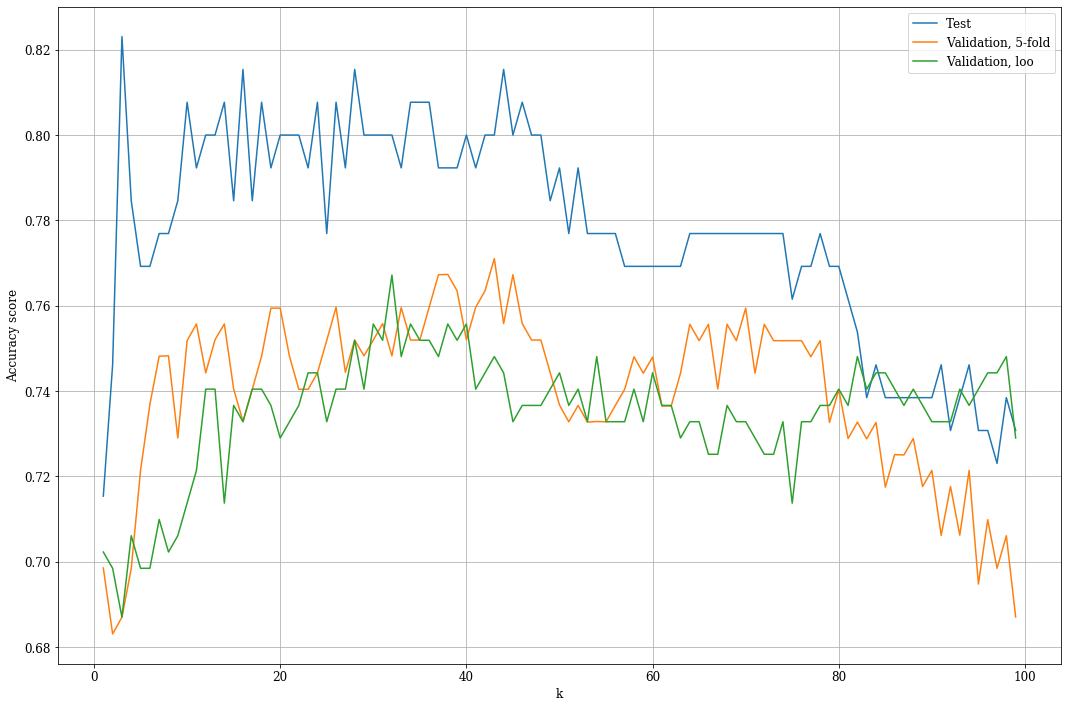

<IPython.core.display.Javascript object>

In [37]:
# Plotting
fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(k_grid, test_scores_2, label="Test")
ax.plot(
    k_grid,
    grid_search_knn_5_fold_2.cv_results_["mean_test_score"],
    label="Validation, 5-fold",
)
ax.plot(
    k_grid,
    grid_search_knn_loo_2.cv_results_["mean_test_score"],
    label="Validation, loo",
)
ax.grid()
ax.set_xlabel("k")
ax.set_ylabel("Accuracy score")
ax.legend()
fig.tight_layout()
plt.show()

The maximum of the test score is placed differently here than with the wrong values. Loo and 5-fold seem to find the maximum more properly in this case, should lead to a better fit.

Next up would be the GAM models, but I couldn't get the stepwise selection to work for GAM, so I cannot do this part. I will plot the partial dependencies and see if they differ for this data though. 

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


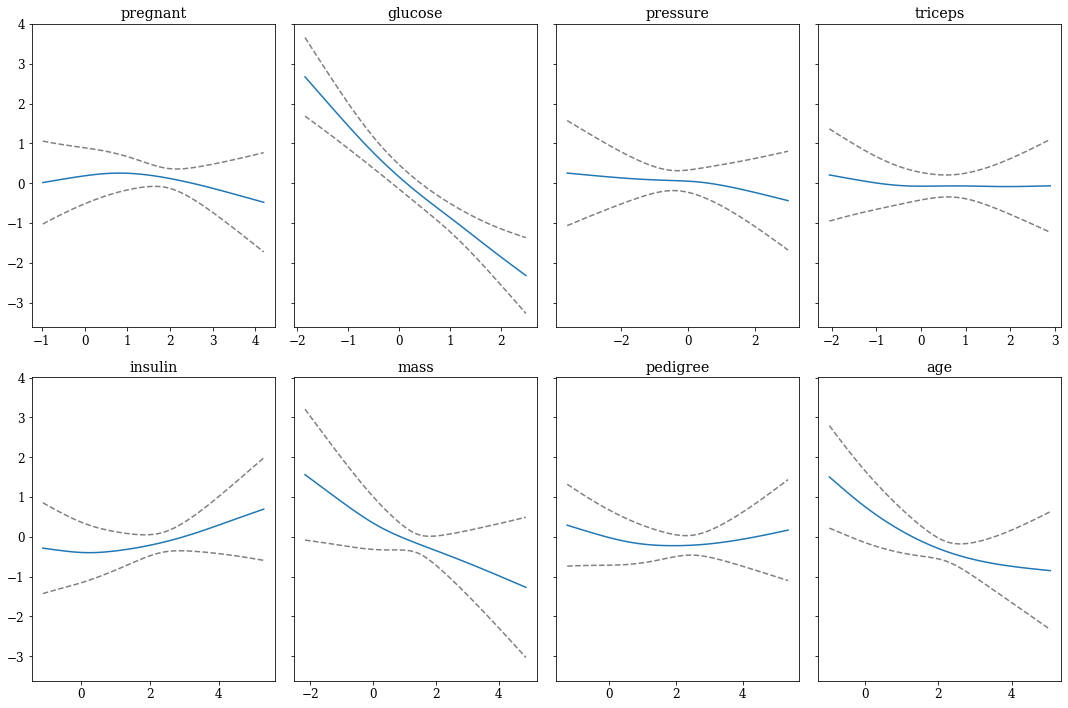

<IPython.core.display.Javascript object>

In [38]:
splines = pygam.s(0)

for i in range(1, len(X_train_3.columns)):
    splines += pygam.s(i)
with np.errstate(invalid="ignore", divide="ignore", over="ignore"):
    gam_test_3 = pygam.LogisticGAM(splines).gridsearch(
        X_train_3.values, y_train_3.values
    )
fig, axes = plt.subplots(2, 4, figsize=[15, 10], sharey=True)
for i, ax in enumerate(axes.ravel()):
    XX = gam_test_3.generate_X_grid(i)
    pdep, confi = gam_test_3.partial_dependence(
        term=i, X=XX, width=0.95, meshgrid=False
    )
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], c="grey", ls="--")
    ax.plot(XX[:, i], confi[:, 1], c="grey", ls="--")
    ax.set_title(X_train_3.columns.values[i])
fig.tight_layout()
plt.show()

The partial dependencies seem much more linear now (although with higher uncertainties). Maybe the 0s in the data made the relationsips seem more non-linear. 

Next I will do Task 2.3 again:

In [39]:
grid_search_tree_2 = sklms.GridSearchCV(
    tree_1, param_grid=hyperparams_tree, iid=False, cv=5
).fit(X_train_3.values, y_train_3.values.ravel())
print(
    f"Best depth: {grid_search_tree_2.best_params_} "
    + f"Test Score: {grid_search_tree_2.score(X_test_3.values, y_test_3.values.ravel()):.2f}"
)

Best depth: {'max_depth': 3} Test Score: 0.79


<IPython.core.display.Javascript object>

Better performance than before somehow. Implies more biased outcomes maybe. The best max_depth is higher than before too.

Next is bagged trees:

In [40]:
grid_search_bag_proba_2 = sklms.GridSearchCV(
    bag_proba, param_grid=hyperparams_bag, cv=5, iid=False
).fit(X_train_3.values, y_train_3.values.ravel())

print(
    f"Best amount of trees: {grid_search_bag_proba_2.best_params_} "
    + f"Test score: {grid_search_bag_proba_2.score(X_test_3, y_test_3.values.ravel()):.2f}"
)

Best amount of trees: {'n_estimators': 48} Test score: 0.78


<IPython.core.display.Javascript object>

Similar to before, but now outperformed by single tree.

Next is random forest:

In [41]:
random_search_forest_2 = sklms.RandomizedSearchCV(
    estimator=forest,
    cv=5,
    iid=False,
    param_distributions=hyperparameters_forest,
    n_iter=100,
).fit(X_train_3.values, y_train_3.values.ravel())

print(
    f"Best hyperparameters: {random_search_forest_2.best_params_} "
    + f"Test score: {random_search_forest_2.score(X_test_3.values, y_test_3.values.ravel()):.2f}"
)

Best hyperparameters: {'n_estimators': 14, 'max_depth': 59} Test score: 0.80


<IPython.core.display.Javascript object>

Much better than on wrong data, but still only slightly better than a single tree of depth 3...

Next is neural network:

In [42]:
random_search_nn_2 = sklms.RandomizedSearchCV(
    estimator=neural_network, param_distributions=hyperparameters_nn, cv=5, iid=False,
).fit(X_train_3.values, y_train_3.values.ravel())
print(
    f"Best hyperparameters: {random_search_nn_2.best_params_} "
    + f"Test score: {random_search_nn_2.score(X_test_3.values, y_test_3.values.ravel()):.2f} "
)

Best hyperparameters: {'learning_rate_init': 0.001023531021899027, 'batch_size': 108, 'alpha': 0.004641588833612782} Test score: 0.81 


<IPython.core.display.Javascript object>

Performance is better for the neural network.

AdaBoost:

In [43]:
random_search_ada_2 = sklms.RandomizedSearchCV(
    estimator=ada, param_distributions=hyperparameters_ada, cv=5, iid=False,
).fit(X_train_3.values, y_train_3.values.ravel())
print(
    f"Best hyperparameters: {random_search_ada_2.best_params_} "
    + f"Test score: {random_search_ada_2.score(X_test_3.values, y_test_3.values.ravel()):.2f} "
)

Best hyperparameters: {'n_estimators': 5, 'learning_rate': 0.5336699231206312} Test score: 0.84 


<IPython.core.display.Javascript object>

With the improved model, AdaBoost still seems to be the better model.

Another big difference here is that the tree performed better. As we can see though, the best tree depth is very low, and the reason the tree has a score that seems high is that the dataset it biased. This implies also that most of the people with invalid reported do not have positive outcome(diabetes), which makes sense as healthy people probably aren't as concerned about properly reporting information about a disease they do not have.

It is important to pay attention to whether your dataset is biased or not, and in reality we should have used a more robust metric than the accuracy score. As we are dealing with a disease, the confusion matrix would have been a much better metric, preferably with a larger penalty for classifying a sick person as healthy than the other way around.